In [1]:
import numpy as np
import matplotlib.pyplot as pyplot
%matplotlib inline

In [2]:
from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from DataReader import load_urm, load_icm, load_target

In [3]:
URM_all = load_urm()

URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.85)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = 0.85)

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 4339 (10.4%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 3086 ( 7.4%) Users that have less than 1 test interactions


## User Based Collaborative Filtering

In [4]:
user_id = 100
shrink = 10

numerator_vector = URM_train[user_id].dot(URM_train.T).toarray().ravel()

user_norms = np.sqrt(np.array(URM_train.T.power(2).sum(axis=0))).ravel()
denominator_vector = user_norms[user_id] * user_norms + shrink + 1e-6

similarity_vector = numerator_vector/denominator_vector

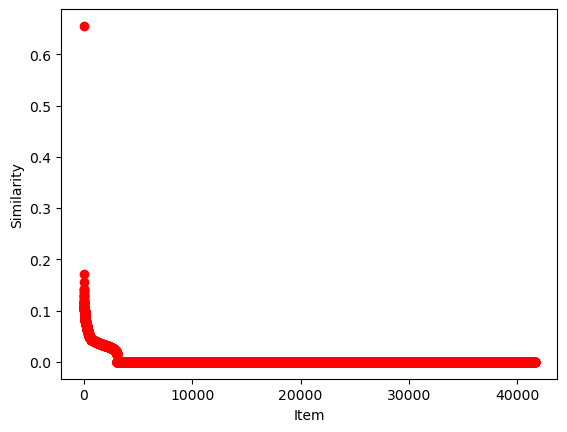

In [5]:
sorted_user_indices = np.argsort(-similarity_vector)

pyplot.plot(similarity_vector[sorted_user_indices], 'ro')
pyplot.ylabel('Similarity')
pyplot.xlabel('Item')
pyplot.show()

In [6]:
from Recommenders.Similarity.Compute_Similarity_Python import Compute_Similarity_Python

similarity_object = Compute_Similarity_Python(URM_train.T, shrink=100,
                                              topK=50, normalize=True,
                                              similarity = "cosine")

W_sparse = similarity_object.compute_similarity()

Similarity column 41629 (100.0%), 428.56 column/sec. Elapsed time 1.62 min


In [7]:
user_id = 100

scores = W_sparse[user_id,:].dot(URM_train).toarray().ravel()

ranking = scores.argsort()[::-1]

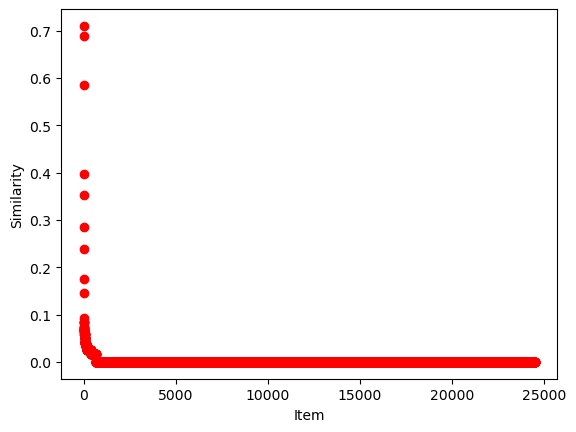

In [8]:
pyplot.plot(scores[ranking], 'ro')
pyplot.ylabel('Similarity')
pyplot.xlabel('Item')
pyplot.show()

In [9]:
ranking[0:10]

array([ 773,  541,  385,  155,  154,  942,  626,  775, 9382,  153],
      dtype=int64)

In [10]:
class UserKNNCFRecommender(object):

    def __init__(self, URM):
        self.URM = URM


    def fit(self, topK=50, shrink=100, normalize=True, similarity="cosine"):

        similarity_object = Compute_Similarity_Python(self.URM.T, shrink=shrink,
                                                      topK=topK, normalize=normalize,
                                                      similarity = similarity)

        self.W_sparse = similarity_object.compute_similarity()


    def recommend(self, user_id, at=None, exclude_seen=True):
        # compute the scores using the dot product

        scores = self.W_sparse[user_id, :].dot(self.URM).toarray().ravel()

        if exclude_seen:
            scores = self.filter_seen(user_id, scores)

        # rank items
        ranking = scores.argsort()[::-1]

        return ranking[:at]


    def filter_seen(self, user_id, scores):

        start_pos = self.URM.indptr[user_id]
        end_pos = self.URM.indptr[user_id+1]

        user_profile = self.URM.indices[start_pos:end_pos]

        scores[user_profile] = -np.inf

        return scores

## Testing the Recommender

In [13]:
recommender = UserKNNCFRecommender(URM_train)
recommender.fit(shrink=0.0, topK=50)

Similarity column 41629 (100.0%), 356.35 column/sec. Elapsed time 1.95 min


## Evaluation

### Number of neighbors

In [1]:
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender

x_tick = [10, 50, 100, 200, 500]
MAP_per_k = []

for topK in x_tick:

    recommender = UserKNNCFRecommender(URM_train)
    recommender.fit(shrink=0.0, topK=topK)

    result_df, _ = evaluator_validation.evaluateRecommender(recommender)

    MAP_per_k.append(result_df.loc[10]["MAP"])

NameError: name 'URM_train' is not defined

### Shrinkage

In [ ]:
pyplot.plot(x_tick, MAP_per_k)
pyplot.ylabel('MAP')
pyplot.xlabel('TopK')
pyplot.show()

In [ ]:
x_tick = [0, 10, 50, 100, 200, 500]
MAP_per_shrinkage = []

for shrink in x_tick:

    recommender = UserKNNCFRecommender(URM_train)
    recommender.fit(shrink=shrink, topK=100)

    result_df, _ = evaluator_validation.evaluateRecommender(recommender)

    MAP_per_shrinkage.append(result_df.loc[10]["MAP"])

In [ ]:
pyplot.plot(x_tick, MAP_per_shrinkage)
pyplot.ylabel('MAP')
pyplot.xlabel('Shrinkage')
pyplot.show()